In [6]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import os
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
from brian2 import *

In [8]:
pwd

'/Users/simoneebert/Documents/Repositories/motion_anticipation_network/Brian/notebooks'

In [9]:
netname = '1D-test'
netdir = f'../output/{netname}'

if not os.path.isdir(netdir):
    os.mkdir(netdir)

In [10]:

# simple system with coupling that oscillates - no input 

# calculate eigenvalues and eigenvectors of the system 

# measure frequency of the system 

# compare to imaginary part of the eigenvalue

#

In [35]:


tauA = -3   # time constant of amacrine cells [s]
tauB = 3   # time constant of bipolar cells [s]

wAB = -4     # synaptic weight from bipolar to amacrine [Hz]
wBA = 9    # synaptic weight from amacrine to bipolar [Hz]

N =1

dt = 0.001
scale_mV = 20.

In [36]:

# # function to make bar stimulus
# def bar(t, x, b, v):

#     if x >=-b+v*t and x <=b+v*t :
#         return 1
#     else:
#         return 0


# # function that defines the temporal kernel
# def biphasic_alpha(t,tau1,tau2,bifw):

#     kern =  (t/(tau1**2)) * np.exp(-t/tau1) * np.heaviside(t,1) -  bifw* (t/(tau2**2)) * np.exp(-t/tau2) * np.heaviside(t,1)
#     return  kern


# # function for gaussialn pooling
# def DOG(x, mu, sig_c):

#     kern =  np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig_c, 2.)))
#     kern = kern / kern.max() # normalize
#     return kern


# # function to simulate OPL inputs as spatiotemporal convolution
# def OPL(stim):

#     N,tps = stim.shape
#     spat = np.zeros((N,tps))
#     temp = np.zeros((N,tps))

#     spat = gaussian_filter1d(stim, sig_c/spacing, axis = 0)
#     #spat = gaussian_filter1d(stim, sig_c/dt, axis = 1)
#     spat = spat/np.max(spat)

#     for n in range(N):
#         spat[n,:] = spat[n,:]/np.max(spat[n,:])
#         # apply temporal filter
#         temp[n,:] = convolve(spat[n,:],temporal_kernel, mode = 'full')[:-len(temporal_kernel)+1]*dt*scale_mV



#     return spat,temp


# # function to transpofm OPL voltage response into input current (divided by capacitance) for bipolars
# def F(temp):

#         N,tps = temp.shape
#         F_array = np.zeros((N,tps))

#         for c in range(N):
#             outst =  np.zeros(tps)
#             outst[:] = temp[c,:].copy()
#             outst_prime = [(outst[i]-outst[i-1])/dt for i in range(0,tps)]
#             F_array[c,:] = outst[:]/tauB + outst_prime

#         return F_array




In [37]:
# define equations for bipolar and amacrine cell

#equation that defines the BC voltage, with input
eqs_bc = """ dv/dt = -(1/tau) * v + vsyn + inp(t,i): volt

tau : second
vsyn : volt/second
"""



#equation that defines the BC voltage, with input
eqs_ac = """ dv/dt = -(1/tau) * v + vsyn : volt

tau : second
vsyn : volt/second
"""
# equation for synaptic coupling
eqs_syn = """vsyn_post = wsyn*v_pre : volt/second (summed)

wsyn: Hz

"""



In [55]:
def simulate(input_matrix,name = None, dir = None):

    start_scope()                # start the stimulation environment
    defaultclock.dt = dt*second  # set integration time step

    N,tps = input_matrix.shape   # extract some parameter
    dur = tps*dt                 # duration of the siulation [s]


    # create neurons
    bc = NeuronGroup(N, eqs_bc,  method = 'euler')
    ac = NeuronGroup(N, eqs_ac,  method = 'euler')

    # create synapses
    synab = Synapses(bc,ac,eqs_syn)       # create synapse form BC to AC
    synba = Synapses(ac,bc,eqs_syn)       # create synapse form AC to BC


    synab.connect(i=0, j=0) # connect sources and targets BC to AC
    synba.connect(i=0, j=0) # connect sources and targets AC to BC



    # set parameter
    bc.tau = tauB * second
    synba.wsyn = wBA * Hz


    ac.tau = tauA * second
    synab.wsyn = wAB * Hz

    bc.v = 2*mV
    bc.v = -4*mV


    inp = TimedArray(input_matrix.T*scale_mV*mV/second,dt=defaultclock.dt)

    # set up monitors to record cell voltages
    monbc = StateMonitor(bc, ('v'), record = True)
    monac = StateMonitor(ac, ('v'), record = True)
    run(dur*second)


    return [monbc.v[0]/mV, monac.v[0]/mV]   # info: here you can change the output to return the voltage of all cells


In [56]:
# make temporal kernel
ftime = np.arange(0,1,dt)


# impulse response simulation

In [57]:
# params to calculate
dur = 3.                      # duration of the simulation [s]
tps = int(dur/dt)             # number of time-points in the simulation [1]
time = np.arange(0,tps)*dt    # time array for the simulation 1xtps, in [s]


# initialize the stimulus
impmat = np.ones((N,tps))
impmat = impmat *0
# impmat[:,int(tps/2)] = 1



In [58]:
# simulate the network
res = simulate(impmat, name = 'gimpulse', dir = netdir)

WARNING    The object 'neurongroup_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_28630/2475790530.py', line 11, in simulate
    bc = NeuronGroup(N, eqs_bc,  method = 'euler') [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_2' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_28630/2475790530.py', line 12, in simulate
    ac = NeuronGroup(N, eqs_ac,  method = 'euler') [brian2.core.base.unused_brian_object]
WARNING    The object 'syn

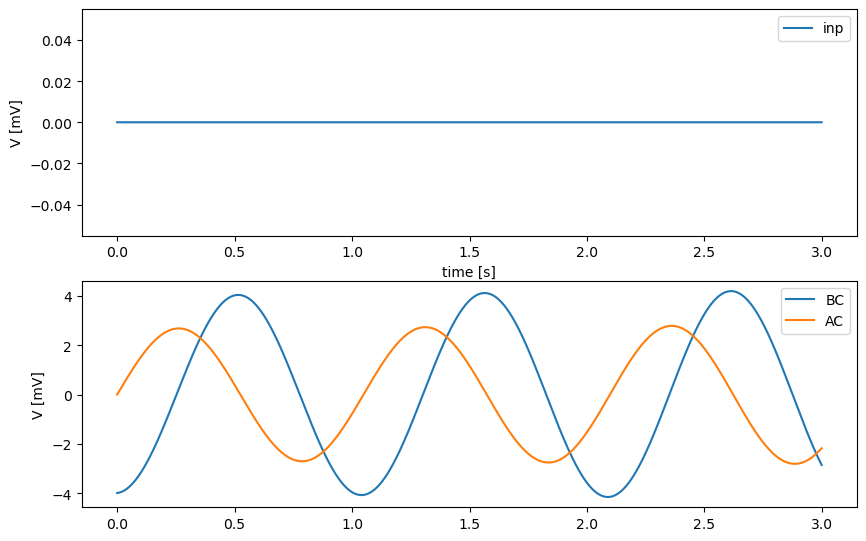

In [59]:
# visualize the network response
fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(3,1)



ax = fig.add_subplot(gs[0,0])
plt.plot(time,impmat[0], label = 'inp')
plt.xlabel('time [s]')
plt.ylabel('V [mV]')
plt.legend()

ax = fig.add_subplot(gs[1,0])
plt.plot(time,res[0], label = 'BC')
plt.plot(time,res[1], label = 'AC')
plt.ylabel('V [mV]')
plt.legend()


In [105]:

# create connectivity matrix
C = np.zeros((N*2,N*2))

C[0,0] = tauB
C[1,1] = tauA
C[0,1] = wBA
C[1,0] = wAB

C

x0= np.array([2,-4])

u,lam,v = np.linalg.svd(C)


In [106]:
u,lam,v

(array([[ 0.90558942, -0.4241554 ],
        [-0.4241554 , -0.90558942]]),
 array([10.40512484,  2.59487516]),
 array([[ 0.4241554 ,  0.90558942],
        [ 0.90558942, -0.4241554 ]]))

In [107]:
np.linalg.eig(C)

EigResult(eigenvalues=array([7.19772989e-17+5.19615242j, 7.19772989e-17-5.19615242j]), eigenvectors=array([[ 0.83205029+0.j        ,  0.83205029-0.j        ],
       [-0.2773501 +0.48038446j, -0.2773501 -0.48038446j]]))

In [108]:
te = np.array([np.exp(C*t) for t in time])


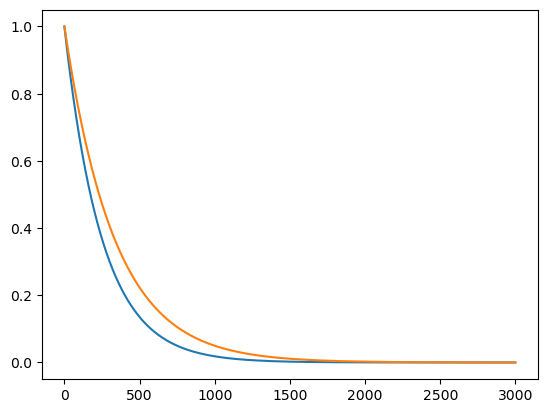

In [109]:
plt.plot(te[:,1,:])

In [110]:
C

array([[ 3.,  9.],
       [-4., -3.]])

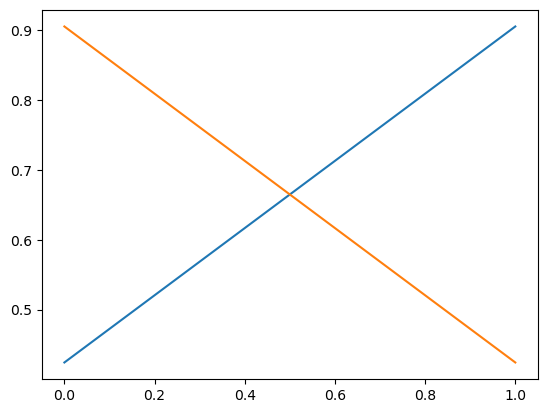

In [111]:
plt.plot(abs(v))

In [112]:
# calulate modes 
r1 = v[:,0]
r2 = v[:,1]

l1 = v[0,:]
l2 = v[1,:]

In [113]:
np.exp(lam0*time).shape

(3000,)

In [114]:
sol0 = np.zeros((2*N,tps))
sol1 = np.zeros((2*N,tps))



for ti,t in enumerate(time):
    sol0[:,ti] = (l1 @ x0) * np.array([r1.real,r1.imag]) @ np.array([np.cos(lam0.real), np.sin(lam0.imag)])
    sol1[:,ti] = (l2 @ x0) * np.array([r2.real,r2.imag]) @ np.array([np.cos(lam1.real), np.sin(lam1.imag)])

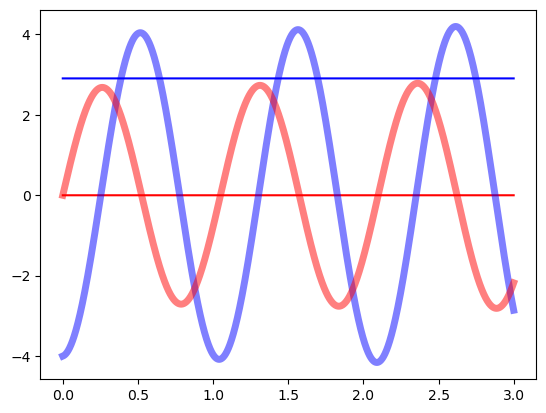

In [115]:
plt.plot(time,sol0[0,:] + sol1[0,:], color = 'b')
plt.plot(time,sol0[1,:] + sol1[1,:], color = 'r')

plt.plot(time,res[0], label = 'BC', linewidth = 5, alpha = 0.5, color = 'b')
plt.plot(time,res[1], label = 'AC', linewidth = 5, alpha = 0.5, color = 'r')

In [116]:
np.exp(lam0*time[4])

(0.999784007775888+0.02078311323125268j)

In [117]:
np.exp(lam1*time)

array([ 1.        +0.j        ,  0.9999865 -0.00519613j,
        0.999946  -0.01039212j, ..., -0.99088861-0.13468391j,
       -0.99157507-0.1295333j , -0.99223476-0.1243792j ])

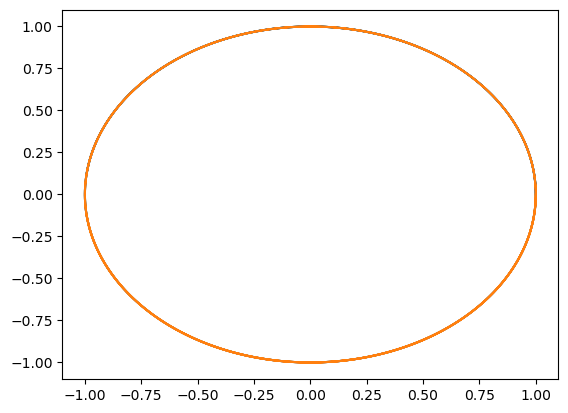

In [118]:
plt.plot(np.exp(lam0*time).real, np.exp(lam0*time).imag)
plt.plot(np.exp(lam1*time).real, np.exp(lam1*time).imag)

Eigenvalues:
[7.19772989e-17+5.19615242j 7.19772989e-17-5.19615242j]

Eigenvectors:
[[ 0.83205029+0.j          0.83205029-0.j        ]
 [-0.2773501 +0.48038446j -0.2773501 -0.48038446j]]


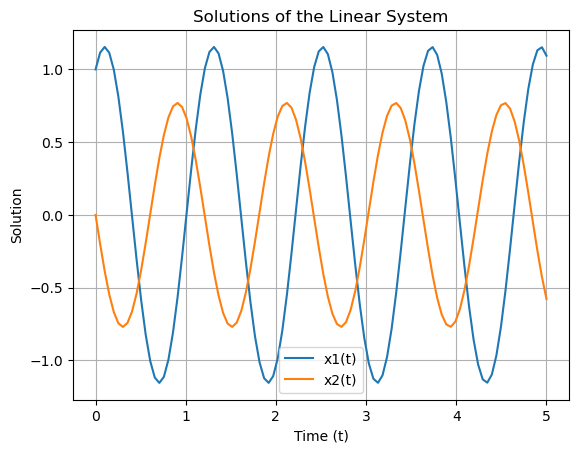

In [119]:
import numpy as np
from scipy.linalg import eig, expm

# Define the coefficient matrix A
A = np.array([[2, 1],
              [1, 2]])
A = C
# Initial conditions
X0 = np.array([1, 0])  # Example: Initial values of x1 and x2

# Time points for solution
t_values = np.linspace(0, 5, 100)  # Solve for t in [0, 5]

# Step 1: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = eig(A)

print("Eigenvalues:")
print(eigenvalues)

print("\nEigenvectors:")
print(eigenvectors)

# Step 2: General solution via matrix exponential
def solve_system(A, X0, t_values):
    solutions = []
    for t in t_values:
        # Matrix exponential at time t
        exp_At = expm(A * t)
        # Solution at time t
        X_t = exp_At @ X0
        solutions.append(X_t)
    return np.array(solutions)

solutions = solve_system(A, X0, t_values)

# Step 3: Print or plot the results
import matplotlib.pyplot as plt

plt.plot(t_values, solutions[:, 0], label="x1(t)")
plt.plot(t_values, solutions[:, 1], label="x2(t)")
plt.xlabel("Time (t)")
plt.ylabel("Solution")
plt.title("Solutions of the Linear System")
plt.legend()
plt.grid()
plt.show()


Eigenvalues:
[7.19772989e-17+5.19615242j 7.19772989e-17-5.19615242j]

Eigenvectors:
[[ 0.83205029+0.j          0.83205029-0.j        ]
 [-0.2773501 +0.48038446j -0.2773501 -0.48038446j]]

Constants c1 and c2:
c1 = (1.201850425154663+3.469443332443555j), c2 = (1.2018504251546633-3.4694433324435554j)


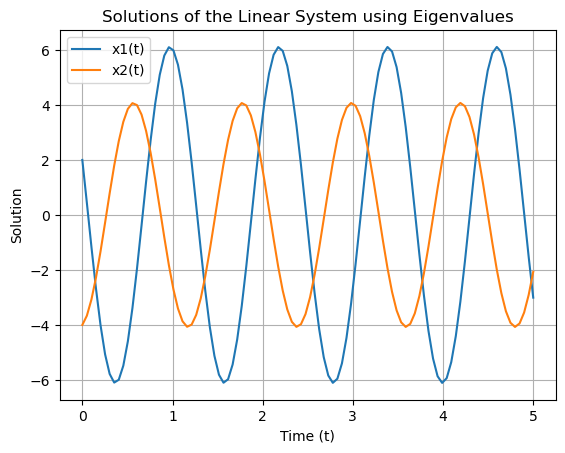

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Define the coefficient matrix A
A = np.array([[2, 1],
              [1, 2]])


A = C
# Initial conditions
X0 = np.array([2, -4])  # Initial values of x1(0) and x2(0)

# Step 1: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(A)

# Display eigenvalues and eigenvectors
print("Eigenvalues:")
print(eigenvalues)

print("\nEigenvectors:")
print(eigenvectors)

# Step 2: Express the solution in terms of eigenvalues and eigenvectors
# General solution: X(t) = c1 * v1 * exp(λ1 * t) + c2 * v2 * exp(λ2 * t)
# Solve for constants c1 and c2 using initial conditions
v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]  # Eigenvectors
λ1, λ2 = eigenvalues[0], eigenvalues[1]          # Eigenvalues

# Solve for constants c1 and c2 using the initial condition X(0) = X0
# X0 = c1 * v1 + c2 * v2
C = np.linalg.solve(np.column_stack((v1, v2)), X0)  # Solve linear system for [c1, c2]
c1, c2 = C

print("\nConstants c1 and c2:")
print(f"c1 = {c1}, c2 = {c2}")

# Step 3: Compute the solution for different times
def X(t):
    # Compute the solution as a function of time
    term1 = c1 * v1 * np.exp(λ1 * t)
    term2 = c2 * v2 * np.exp(λ2 * t)
    return term1 + term2

sol1[:,ti] = (l2 @ x0) * np.array([r2.real,r2.imag]) @ np.array([np.cos(lam1.real), np.sin(lam1.imag)])
# Time range for the solution
t_values = np.linspace(0, 5, 100)  # t in [0, 5]
solutions = np.array([X(t) for t in t_values])

# Step 4: Plot the results
plt.plot(t_values, solutions[:, 0], label="x1(t)")
plt.plot(t_values, solutions[:, 1], label="x2(t)")
plt.xlabel("Time (t)")
plt.ylabel("Solution")
plt.title("Solutions of the Linear System using Eigenvalues")
plt.legend()
plt.grid()
plt.show()


WARNING    /Users/simoneebert/opt/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
 [py.warnings]
WARNING    /Users/simoneebert/opt/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
 [py.warnings]


[[ 3.  9.]
 [-4. -3.]]


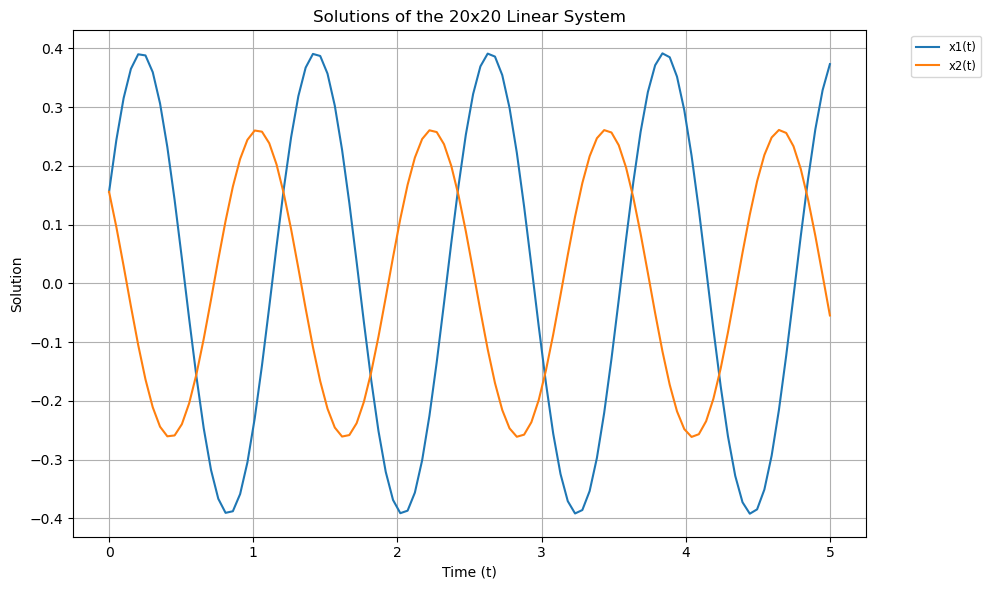

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Define the coefficient matrix A (example: 20x20)
np.random.seed(42)  # For reproducibility
n = 2  # Size of the system
A = np.random.rand(n, n)  # Random 20x20 matrix

# create connectivity matrix
C = np.zeros((N*2,N*2))

C[0,0] = tauB
C[1,1] = tauA
C[0,1] = wBA
C[1,0] = wAB

C

x0= np.array([2,-4])

A = C
print(A)
# Define initial condition (size n)
X0 = np.random.rand(n)

# Step 1: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(A)

# Eigenvector matrix (columns are eigenvectors)
V = eigenvectors

# Step 2: Solve for constants c1, c2, ..., cn
# X0 = V @ C --> C = V^-1 @ X0
C = np.linalg.solve(V, X0)  # Solving for constants C = [c1, c2, ..., cn]

# Step 3: Define the solution as a function of time
def X(t):
    # Compute the solution as a sum of eigenvector components
    terms = [C[i] * V[:, i] * np.exp(eigenvalues[i] * t) for i in range(n)]
    return np.sum(terms, axis=0)  # Sum up all contributions

# Time range for the solution
t_values = np.linspace(0, 5, 100)  # t in [0, 5]
solutions = np.array([X(t) for t in t_values])

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
for i in range(n):
    plt.plot(t_values, solutions[:, i], label=f"x{i+1}(t)")

plt.xlabel("Time (t)")
plt.ylabel("Solution")
plt.title("Solutions of the 20x20 Linear System")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid()
plt.tight_layout()
plt.show()
